In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import tarfile
tar = tarfile.open("drive/My Drive/Datasets/Dataset.tar.gz")
tar.extractall()
tar.close()

In [1]:
### Importing Libraries.........................
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
from skimage import segmentation
import torch.nn.init
import matplotlib.pyplot as plt
from IPython.display import clear_output as clr
from torchsummary import summary
import os

In [6]:
use_cuda = False

In [7]:
# Simple CNN model with valid paddings
class MyNet(nn.Module):
    def __init__(self,input_dim, nChannel = 100, nConv = 2, nLast = 500):
        super(MyNet, self).__init__()
        self.nChannel = nChannel
        self.nConv = nConv
        self.conv1 = nn.Conv2d(input_dim, self.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(self.nChannel, momentum = 0.4)
        self.conv2 = []
        self.bn2 = []
        for i in range(self.nConv-1):
            self.conv2.append( nn.Conv2d(self.nChannel, self.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(self.nChannel , momentum = 0.4))
        self.conv3 = nn.Conv2d(self.nChannel,nLast, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(nLast, momentum = 0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(self.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

In [8]:
def get_data(image_path, img_size = (481,321)):
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, img_size, interpolation=cv2.INTER_AREA)
    data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
    
    im2 = torch.tensor(cv2.Canny(im,200,200)).cuda()
#     data[0,0,:,:] = im2
#     data[0,1,:,:] = im2
#     data[0,2,:,:] = im2
    if use_cuda:
        data = data.cuda()
    data = Variable(data)
    return im, im2, data

In [9]:
# slic getting the segmentatoin labels ...
def get_labels(im, plot = False):
    labels = segmentation.slic(im, compactness=30, n_segments=10000)  # getting the labels

    # Finding the unique color segment labels ....
    labels = labels.reshape(im.shape[0]*im.shape[1])
    u_labels = np.unique(labels)
    l_inds = []

    ## finding he indices where that label exist....
    for i in range(len(u_labels)):
        l_inds.append( np.where(labels == u_labels[i])[0])
        
    if(plot):
      plt.imshow(labels.reshape(im.shape[0],im.shape[1]))
    
    return l_inds

In [14]:
# Hyper parameters and initializations ...........
lr = 0.1
maxIter = 500
nChannel = 200
nConv = 10
minLabels = 6
nLast = 1000

im, im2, data = get_data('../../sample2.jpg')
l_inds = get_labels(im,plot= True)
# Training the model...
model = MyNet(data.size(1), nChannel = nChannel , nConv = nConv, nLast = nLast)
if use_cuda:
    model.cuda()
    for i in range(nConv-1):
        model.conv2[i].cuda()
        model.bn2[i].cuda()

AssertionError: Torch not compiled with CUDA enabled

In [14]:
# Setting model to training mode. ....
model.train()
summary(model, input_size = [[3, 100,100]])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 200, 100, 100]           5,600
       BatchNorm2d-2        [-1, 200, 100, 100]             400
            Conv2d-3       [-1, 1000, 100, 100]         201,000
       BatchNorm2d-4       [-1, 1000, 100, 100]           2,000
Total params: 209,000
Trainable params: 209,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 183.11
Params size (MB): 0.80
Estimated Total Size (MB): 184.02
----------------------------------------------------------------


In [ ]:
# Cross Entropy loss between the max of all channels with the 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
label_colours = np.random.randint(255,size=(100,3))  # selecting some random colors ...

In [ ]:
def train_model(image_path):
    diff = 9999
    curr_loss = 0
    old_loss = curr_loss + diff
    
    im2, im, data = get_data(image_path)
    l_inds = get_labels(im2)
    
    
    
    nLabels = 1000
    
    for batch_idx in range(maxIter):
      
        if nLabels <= minLabels:
            print ("nLabels", nLabels, "reached minLabels", minLabels, ".")
            im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
            im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
            plt.imshow(im_target_rgb)
            plt.show()
            break

        if diff < 0.001:
            print("I had Enough of taking sips :) ...")
            im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
            im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
            plt.imshow(im_target_rgb )
            plt.show()
            break

        # Forward Propagation ......
        optimizer.zero_grad()
        output = model(data)[0]

        # converting axis to data first format ....
        output = output.permute(1,2,0).contiguous().view(-1, nLast)
        ignore, target = torch.max( output, 1 )
        im_target = target.data.cpu().numpy()
        nLabels = len(np.unique(im_target))

        # Superpixel Refinement 
        for i in range(len(l_inds)):
            labels_per_sp = im_target[l_inds[i]]

            # number of unique colors obtained in single super pixel .....along all channels...
            u_labels_per_sp = np.unique(labels_per_sp) 
            # hist : histogram of colors labels ...
            hist = np.zeros(len(u_labels_per_sp))
            for j in range(len(hist)):
                hist[j] = len(np.where(labels_per_sp == u_labels_per_sp[j])[0])
            # assinging the highest histogram value to whole super pixel
            im_target[l_inds[i]] = u_labels_per_sp[np.argmax(hist)]

        # Converting the refined labels to torch variable
        target = torch.from_numpy(im_target)
        if use_cuda:
            target = target.cuda()
        target = Variable(target)

        # loss between all channels and target 
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.item()
        diff = abs(old_loss - curr_loss)
        old_loss = curr_loss
        torch.cuda.empty_cache()

        print (batch_idx, '/', maxIter, ':', nLabels, curr_loss)
        
            
    return curr_loss

In [18]:
imaxIter = 100
for num in [1,2,3,4,5]:
  path1 = 'Dataset/camera'+str(num)+'/JPEGImages'
  losses = []
  count = 0
  flag = 0
  list_path = os.listdir(path1)
  for idx in list(np.random.randint(len(list_path), size = [20])):
      path = list_path[idx]
      img_path = (path1 + '/' + path)
      loss = train_model(img_path)
      print(count)
      clr(wait = True)
      losses.append(loss)
      count+=1
      if(count > 10 and np.mean(losses[-10:])<0.5):
          print("Done")
          flag = 1
          break
      torch.cuda.empty_cache()
  if(flag):
    break

0 / 500 : 489 6.156576633453369
1 / 500 : 478 6.073270797729492
2 / 500 : 474 6.055062770843506
3 / 500 : 472 5.954965591430664
4 / 500 : 469 5.8308539390563965
5 / 500 : 472 5.760502815246582
6 / 500 : 464 5.6428542137146
7 / 500 : 466 5.509000301361084
8 / 500 : 473 5.3375983238220215
9 / 500 : 455 5.2335052490234375
10 / 500 : 453 5.07401704788208
11 / 500 : 441 4.936174392700195
12 / 500 : 452 4.778536319732666
13 / 500 : 450 4.622984886169434
14 / 500 : 430 4.4278364181518555
15 / 500 : 424 4.245500564575195
16 / 500 : 411 4.037087917327881
17 / 500 : 407 3.8246684074401855
18 / 500 : 391 3.6127421855926514
19 / 500 : 384 3.3753502368927
20 / 500 : 363 3.151606559753418
21 / 500 : 361 2.9315686225891113
22 / 500 : 335 2.7063612937927246
23 / 500 : 320 2.5016374588012695
24 / 500 : 306 2.2780303955078125
25 / 500 : 284 2.074679136276245
26 / 500 : 263 1.8911994695663452
27 / 500 : 248 1.7225171327590942
28 / 500 : 235 1.5773022174835205
29 / 500 : 214 1.4461458921432495
30 / 500 : 

ValueError: ignored

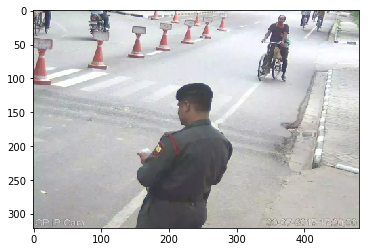

In [43]:
im2,im, data = get_data('Dataset/camera4/torch.save(model.state_dict(), 'model.h5')JPEGImages/00001.jpg')
# im2,im, data = get_data(img_path)

# l_inds = get_labels(im2)
plt.imshow(im2)
plt.show()

In [ ]:
torch.cuda.empty_cache()
output = model(data)[0]
output = output.permute(1,2,0).contiguous().view(-1, nLast)
ignore, target = torch.max( output, 1)
im_target = target.data.cpu().numpy()
torch.cuda.empty_cache()

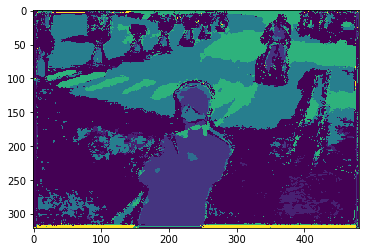

In [45]:
plt.imshow(im_target.reshape((321,481)))

In [ ]:
torch.cuda.empty_cache()
from skimage import data, segmentation, color
from skimage.future import graph

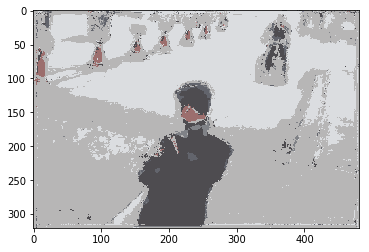

In [47]:
g = graph.rag_mean_color(im2, im_target.reshape((321,481)), mode='similarity')
labels2 = graph.cut_normalized(im_target.reshape((321,481)), g, thresh=0.01)
out2 = color.label2rgb(labels2, im2, kind='avg')


plt.imshow(out2)
# plt.savefig("ncut.png")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.h5')